# P2 - Computer Vision: Editing MNIST Challenge Images Using XAI Techniques
### Elena Ardura and Emma Rey

Our goal was to minimally modify the challenge images so that the provided SmallCNN predicted the correct class while keeping at least 60% of the original pixels unchanged. To understand which regions should be edited, we explored several XAI techniques such as Saliency Maps, Integrated Gradients and Smoothgrad.

In [25]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd

device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)

print('Device:', device)

Device: mps


In [26]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [ ]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False)
#model = torch.load(model_name, map_location=device)
model.to(device)
model.eval()

/var/folders/7x/lsf3fbc14ldfy85pcnmhcm3m0000gn/T/ipykernel_27237/2863976618.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name, map_location=d

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

3_label7.png: Pred: 3, Label: 7
1_label3.png: Pred: 1, Label: 3
4_label2.png: Pred: 6, Label: 2
2_label3.png: Pred: 1, Label: 3
0_label5.png: Pred: 1, Label: 5


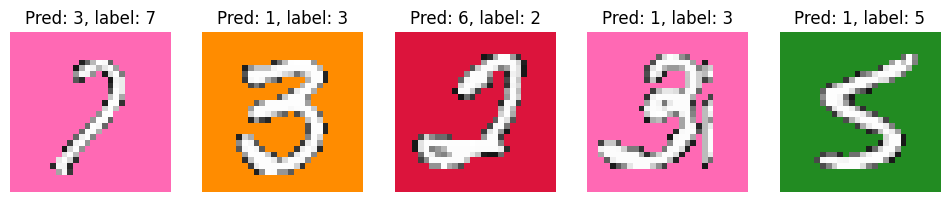

In [28]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

### STAGE 1: SALIENCY MAPS

Before applying the methodology, we first evaluated all five challenge images using gradient-based saliency. Only two digits (the “7” and the “2”) produced meaningful saliency maps with non-vanishing gradients. These were the only images for which saliency-guided editing was possible.


#### Methodology

We applied a gradient-based editing strategy, used only on the images where the model preserved non-vanishing gradients. The process was:

1. **Saliency on the true logit, take the absolute value, and normalize.**

- Using the logit instead of the softmax avoids saturation and yields more stable gradients.

2. **Top-k% importance mask**

- Select the top 12–39% most salient pixels.
- This restricts all edits to a minimal, targeted region.

3. **Local edits inside the mask**

- Noise removal: replace bright or irrelevant pixels with white.
- Stroke reinforcement: slightly darken meaningful strokes to strengthen the true digit signal.

4. **Iterative correction**

- After each modification, re-run the model.
- Keep the first version that flips the prediction to the correct label.

5. **Constraint validation**

- Edited area must be ≤ 40% of the pixels.
- The final prediction must match the true class.

In [29]:
# Funciones necesarias luego
def predict_np(img_np):
    """ img_np: numpy array HWC [0,1] """
    img_t = torch.from_numpy(img_np.transpose(2,0,1)).unsqueeze(0).float().to(device)
    with torch.no_grad():
        pred = int(model(img_t).argmax(dim=1).item())
    return pred

In [30]:
def grad_norm_on_input(model, x, y_idx):
    x = x.clone().detach().requires_grad_(True)
    logits = model(x)
    target = logits[0, y_idx]
    model.zero_grad(set_to_none=True)
    target.backward()
    g = x.grad.detach().view(-1)
    return float(torch.linalg.vector_norm(g, ord=2).cpu())

In [31]:
def saliency_true_logit(model, x, y_idx):
    """
    Saliency respecto al LOGIT de la clase correcta: |∇_x logit_y|.
    x: (1,C,28,28) en [0,1]
    """
    x = x.clone().detach().requires_grad_(True)
    logits = model(x)                 # pre-softmax
    target = logits[0, y_idx]
    model.zero_grad(set_to_none=True)
    target.backward()
    g = x.grad.detach().abs()[0]      # (C,H,W)
    if g.shape[0] > 1:
        g = g.mean(dim=0)
    else:
        g = g[0]
    g = g - g.min()
    g = g / (g.max() + 1e-8)
    return g.cpu().numpy()            # (H,W) en [0,1]


In [32]:
def show_saliency_for_file(img_path, target="true", overlay=True, cmap="inferno"):
    """
    target: "true" usa la clase del nombre de archivo (último dígito del stem),
            "pred" usa la clase que predice el modelo en crudo.
    overlay: si True, superpone el saliency semitransparente sobre el gris.
    """
    # Carga y tensor
    img28 = Image.open(img_path).convert("RGB").resize((28,28))
    x = to_tensor(img28).unsqueeze(0).to(device)  # (1,C,28,28) en [0,1]
    H, W = x.shape[-2:]

    # Etiquetas y gradiente
    with torch.no_grad():
        logits = model(x)
        pred = int(output.argmax(dim=1).item())
        probs = torch.softmax(logits, dim=1).cpu().numpy() 

    true_label = int(Path(img_path).stem[-1])
    y_idx = true_label if target == "true" else pred

    s_map = saliency_true_logit(model, x, y_idx)       # (H,W) en [0,1]
    gnorm = grad_norm_on_input(model, x, y_idx)

    # Plots
    fig, axes = plt.subplots(1, 3 if overlay else 2, figsize=(12, 4))
    ax0 = axes[0]; ax1 = axes[1]
    ax0.imshow(img28.convert("L"), cmap="gray", vmin=0, vmax=255)
    ax0.set_title(f"Original\npred={pred} (true={true_label})")
    ax0.axis("off")

    ax1.imshow(s_map, cmap=cmap)
    ax1.set_title(f"Saliency |∇ logit_{y_idx}|\n‖grad‖={gnorm:.2e}")
    ax1.axis("off")

    if overlay:
        ax2 = axes[2]
        ax2.imshow(img28.convert("L"), cmap="gray", vmin=0, vmax=255)
        ax2.imshow(s_map, cmap=cmap, alpha=0.45)
        ax2.set_title("Overlay")
        ax2.axis("off")

    plt.suptitle(f"{Path(img_path).name}  —  objetivo: {y_idx} ({'true' if target=='true' else 'pred'})")
    plt.tight_layout()
    plt.show()

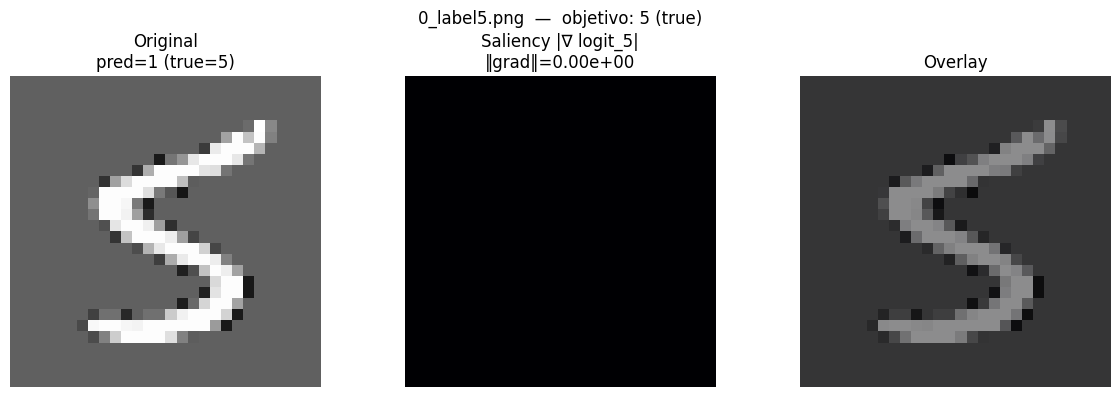

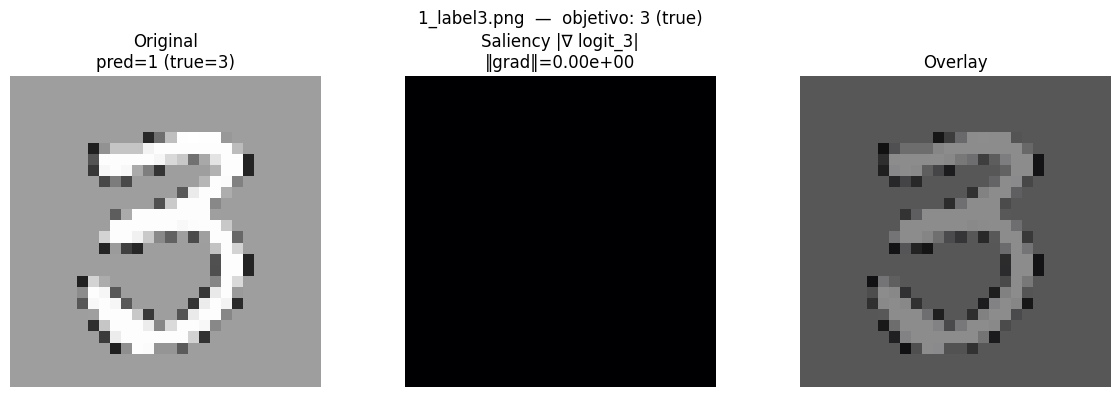

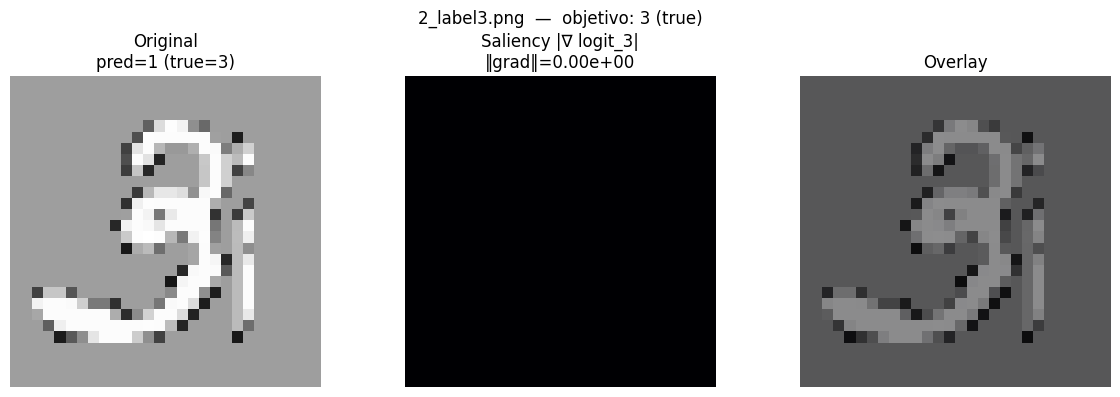

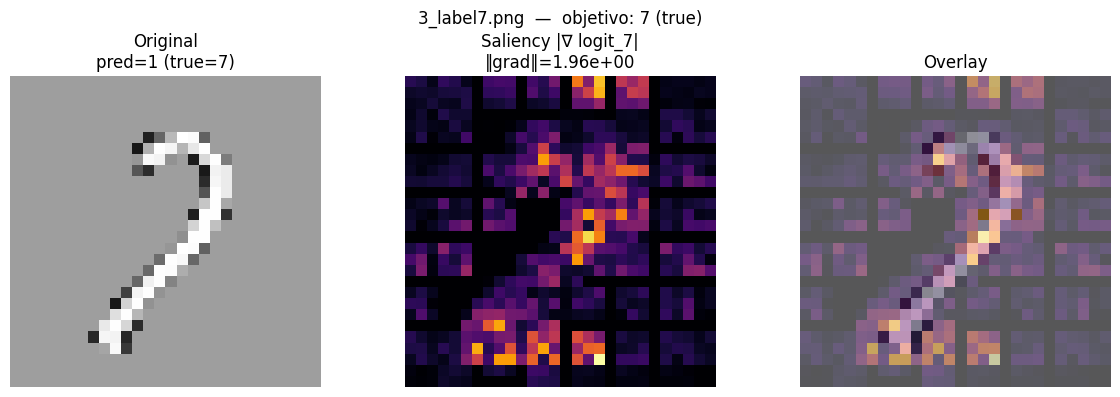

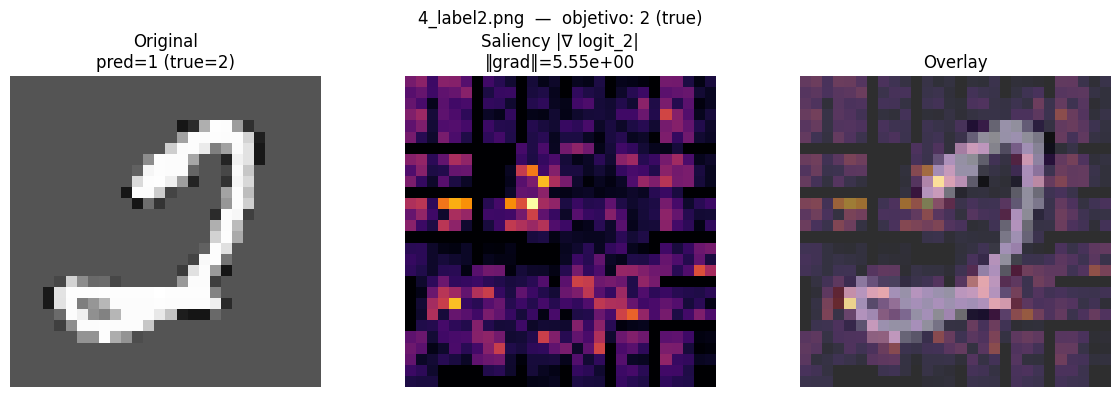

In [33]:
one_file = Path("../data/MNIST/challenge/")
files = sorted(one_file.glob("*.png"))
for f in files:
    show_saliency_for_file(f, target="true", overlay=True)

In [34]:
def edit_with_saliency_minimal(img_pil, true_label, top_pct=0.15, darken_amt=0.30):
    """
    Edita SOLO dentro de la máscara top-k del saliency del logit verdadero:
      A) borrar ruido claro (llevar a blanco)
      B) reforzar trazo (oscurecer un poco)
    Devuelve (edited_np_uint8, pred_before, pred_after)
    """
    img28 = img_pil.convert("RGB").resize((28,28), Image.BILINEAR)
    x = to_tensor(img28).unsqueeze(0).to(device)

    # saliency & mask
    s_map = saliency_true_logit(model, x, true_label)  # (H,W) en [0,1]
    th = np.percentile(s_map, 100*(1 - top_pct))
    mask = (s_map >= th).astype(np.float32)  # (H,W) {0,1}

    # a numpy [0,1]
    arr = (np.array(img28).astype(np.float32) / 255.0)
    pred0 = predict_np(arr)
    
    # PASO A: borrar ruido claro dentro de la máscara
    outA = arr.copy()
    bright = (outA.mean(axis=2) > 0.6).astype(np.float32)
    mA = (mask * bright)[:, :, None]
    outA = outA*(1 - mA) + 1.0*mA
    predA = predict_np(outA)

    if predA == true_label:
        return (outA*255).astype(np.uint8), pred0, predA

    # PASO B: reforzar trazo oscuro dentro de la máscara
    outB = outA.copy()
    dark = (outB.mean(axis=2) < 0.5).astype(np.float32)
    mB = (mask * dark)[:, :, None]
    outB = np.clip(outB - darken_amt*mB, 0, 1)
    predB  = predict_np(outB)
    
    return (outB*255).astype(np.uint8), pred0, predB

In [35]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [36]:
def try_fix_with_saliency(img_path, top_pcts=(0.12, 0.18, 0.24), darken_amt=0.30, grad_min=1e-6):
    """
    Intenta corregir una imagen usando saliency si hay gradiente suficiente.
    Devuelve dict con resultado y guarda en .../edited/ si es válido.
    """
    edited_dir = img_path.parent / "edited"
    edited_dir.mkdir(parents=True, exist_ok=True)

    img_pil = Image.open(img_path).convert("RGB")
    true_label = int(Path(img_path).stem.split("label")[-1][0])  # último dígito del stem

    # mide norma de gradiente (respecto al logit de la clase verdadera)
    x28 = to_tensor(img_pil.convert("RGB").resize((28,28), Image.BILINEAR)).unsqueeze(0).to(device)
    gnorm = grad_norm_on_input(model, x28, true_label)

    if gnorm < grad_min:
        # sin gradiente útil: no intentamos saliency aquí
        return {"ok": False, "skipped": False, "reason": "vanishing_gradients", "grad_norm": gnorm}

    best = None
    for tp in top_pcts:
        edited_np, pred_before, pred_after = edit_with_saliency_minimal(img_pil, true_label, top_pct=tp, darken_amt=darken_amt)
        edited = Image.fromarray(edited_np)

        p = calculate_edit_percentage(img_pil, edited)
        edited_np = (np.array(edited).astype(np.float32) / 255.0)
        pred_final = predict_np(edited_np)
    
        logline = f"{img_path.name} | before={pred_before} -> after={pred_final} | true={true_label} | edit%={p:.1f} | top_pct={tp} | grad_norm={gnorm:.2e}"
        print(logline)

        if (pred_final == true_label) and (p <= 40.0):
            edited.save(edited_dir / img_path.name)
            best = {"ok": True, "pred_before": pred_before, "pred_after": pred_final,
                    "edit_pct": p, "top_pct": tp, "grad_norm": gnorm}
            break

    if best is None:
        best = {"ok": False, "pred_before": pred_before, "pred_after": pred_final,
                "edit_pct": p, "top_pct": tp, "grad_norm": gnorm}
    return best

In [37]:
challenge_dir = Path("../data/MNIST/challenge") 
files = sorted(challenge_dir.glob("*.png"))

ok = 0
attempted = 0
skipped_grad = 0
for f in files:
    r = try_fix_with_saliency(f, top_pcts=(0.12, 0.18, 0.24), darken_amt=0.30, grad_min=1e-6)
    if r.get("skipped", False):
        continue
    attempted += 1
    if r.get("reason") == "vanishing_gradients":
        skipped_grad += 1
        print(f"  -> saltada (vanishing gradients): {f.name} (‖grad‖={r['grad_norm']:.2e})")
    if r["ok"]:
        ok += 1

print(f"\nHe intentado corregir {attempted} imágenes (saltadas por gradiente: {skipped_grad}).")
print(f"Guardadas válidas (pred correcta y ≤40% editado): {ok}")
print("Se han guardado en:", challenge_dir / "edited")


  -> saltada (vanishing gradients): 0_label5.png (‖grad‖=0.00e+00)
  -> saltada (vanishing gradients): 1_label3.png (‖grad‖=0.00e+00)
  -> saltada (vanishing gradients): 2_label3.png (‖grad‖=0.00e+00)
3_label7.png | before=3 -> after=7 | true=7 | edit%=10.2 | top_pct=0.12 | grad_norm=1.96e+00
4_label2.png | before=6 -> after=2 | true=2 | edit%=2.2 | top_pct=0.12 | grad_norm=5.55e+00

He intentado corregir 5 imágenes (saltadas por gradiente: 3).
Guardadas válidas (pred correcta y ≤40% editado): 2
Se han guardado en: ../data/MNIST/challenge/edited


### STAGE 2: SMOOTHGRAD

Because several images produced completely black saliency maps due to vanishing gradients, we explored SmoothGrad as an alternative. SmoothGrad averages gradients over multiple noisy copies of the input image, which helps reveal signal hidden under flat or unstable gradients. The intuition is that adding controlled noise perturbs the model slightly and exposes variations in the gradient that would otherwise remain zero.

After applying SmoothGrad, all challenge images showed meaningful saliency maps with color, instead of the uniform black maps obtained with vanilla gradients. This confirmed that the model still had some sensitivity to the input, but that the raw gradient was too unstable or saturated to reveal it.

However, despite obtaining visually richer attribution maps, SmoothGrad did not meaningfully improve the correction results. The only digits that we successfully fixed using this method were the ones we had already rescued in Stage 1 (the “7” and the “2”). For the remaining images, SmoothGrad highlighted broader regions but did not provide actionable, localized gradients strong enough to guide minimal edits within the 40% pixel-change constraint.

In summary, SmoothGrad solved the visualization problem (no more black maps), but not the underlying optimization issue.

Processing: 0_label5.png


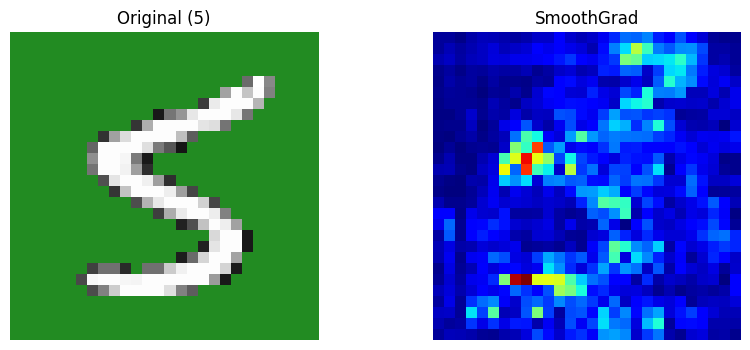

Processing: 1_label3.png


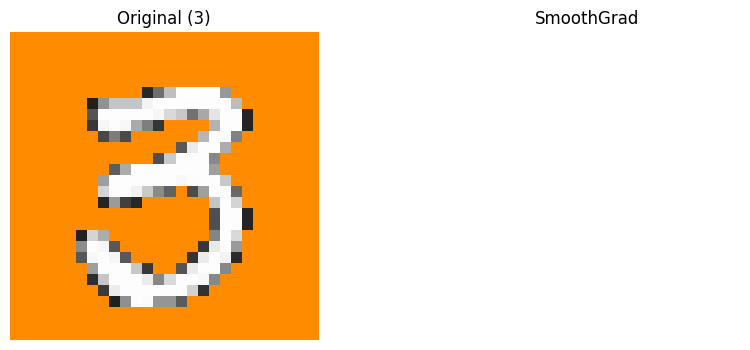

Processing: 2_label3.png


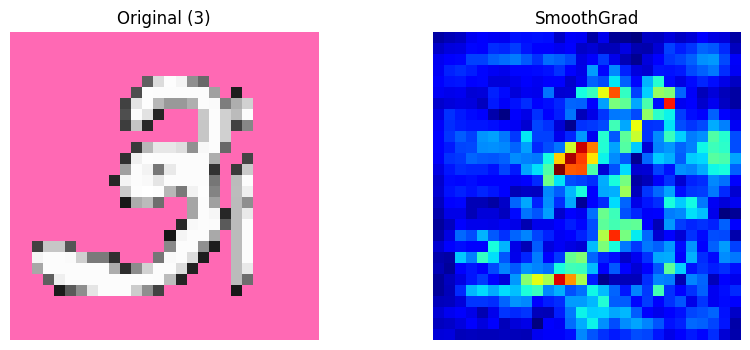

Processing: 3_label7.png


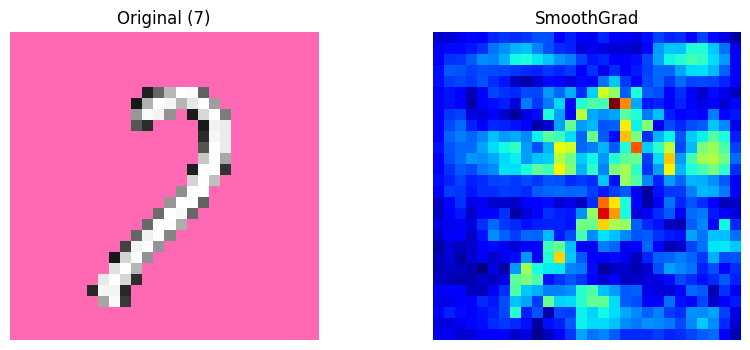

Processing: 4_label2.png


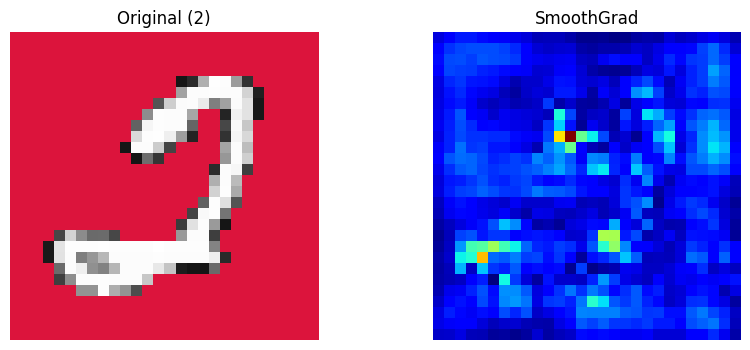

In [38]:
def smoothgrad(model, x, y, n=100, noise=0.3):
    grads = torch.zeros_like(x)
    for _ in range(n):
        noise_tensor = torch.randn_like(x) * noise
        x_noisy = (x + noise_tensor).clamp(0,1)
        x_noisy.requires_grad_(True)
        
        out = model(x_noisy)
        score = out[0, y]

        model.zero_grad(set_to_none=True)
        score.backward()

        grads += x_noisy.grad.detach()

    grads = grads.abs().mean(1, keepdim=True)
    grads = grads[0] / grads.max()
    return grads.squeeze().cpu().numpy()

def show_smoothgrad(img_path):
    img = Image.open(img_path).convert("RGB").resize((28,28))
    x = to_tensor(img).unsqueeze(0).to(device)
    y_true = int(Path(img_path).stem[-1])

    sg = smoothgrad(model, x, y_true)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Original ({y_true})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(sg, cmap="jet")
    plt.title("SmoothGrad")
    plt.axis("off")
    plt.show()

# Ejecutar SmoothGrad sobre todas las imágenes del challenge
challenge_dir = Path("../data/MNIST/challenge")
files = sorted(challenge_dir.glob("*.png"))

for f in files:
    print("Processing:", f.name)
    show_smoothgrad(f)




### STAGE 3: INTEGRATED GRADIENTS

After observing that standard saliency and SmoothGrad did not consistently provide actionable attributions, we tried **Integrated Gradients (IG)**. IG accumulates gradients along a path from a baseline image (in our case, a black image) to the original input, which helps mitigate local saturation and provides a more stable notion of feature importance.

For each challenge image, we computed IG with respect to the **true label**, averaging gradients over 50 interpolated steps between the baseline and the input. This produces a normalized importance map in \([0,1]\) that highlights pixels which contribute most to increasing the true-class logit.

#### Methodology

1. **Integrated Gradients map**  
   - For each image \(x\), we used a zero baseline and computed IG for the true class.  
   - We took the absolute value and averaged over channels to obtain a 2D importance map.

2. **Top-k% mask and whitening**  
   - We tested several candidate percentages (10–39%) of the most important pixels according to IG.  
   - For each percentage, we built a binary mask over the top-k% pixels and set those pixels to white, effectively removing the features that IG identified as most responsible for the wrong prediction.

3. **Selection under the 40% constraint**  
   - After each edit, we re-evaluated the model.  
   - We accepted the first configuration where:
     - the prediction matched the true digit, and  
     - the fraction of changed pixels was ≤ 40%.

### Results

This IG-based whitening strategy successfully corrected two images, both corresponding to the digit “3”. In these cases, IG highlighted specific strokes that were misleading the classifier, and removing them was enough to flip the prediction while staying below the 40% edit threshold.

For the remaining images, IG still produced interpretable maps, but whitening the most influential pixels either did not change the prediction or required modifying more than 40% of the image. Therefore, Integrated Gradients improved over plain saliency in terms of usefulness (especially for the “3” digits), but its impact was still limited by the model’s behaviour and the strict pixel-change constraint.


In [39]:
def integrated_gradients_saliency(model, x, target_label, m_steps=50, baseline=None):
    """
    x: tensor [1, C, H, W] en [0,1]
    target_label: int
    Devuelve un mapa (H,W) normalizado en [0,1] con |IG|.
    """
    model.eval()
    x = x.to(device)

    if baseline is None:
        baseline = torch.zeros_like(x).to(device)

    # interpolamos entre baseline y x
    alphas = torch.linspace(0.0, 1.0, steps=m_steps).view(-1, 1, 1, 1).to(device)
    scaled_inputs = baseline + alphas * (x - baseline)  # [m_steps, C, H, W]

    scaled_inputs.requires_grad_(True)
    outputs = model(scaled_inputs)
    scores = outputs[:, target_label].sum()  # sum para backprop sobre todos los steps

    model.zero_grad(set_to_none=True)
    scores.backward()
    grads = scaled_inputs.grad.detach()      # [m_steps, C, H, W]

    # media de gradientes a lo largo del camino
    avg_grads = grads.mean(dim=0, keepdim=True)  # [1, C, H, W]

    # fórmula IG: (x - baseline) * avg_grad
    ig = (x - baseline) * avg_grads          # [1, C, H, W]
    ig = ig.abs().mean(1, keepdim=True)      # colapsa canales -> [1,1,H,W]
    ig = ig[0,0]                             # [H,W]

    # normalizar a [0,1]
    ig = ig / (ig.max() + 1e-8)
    return ig.cpu().numpy()

In [40]:
def edit_image_with_ig_whitening(img_path, pct=0.37, m_steps=50):
    """
    - Calcula Integrated Gradients wrt la etiqueta verdadera.
    - Toma el top 'pct' de píxeles del mapa.
    - Sustituye esos píxeles por blanco.
    - Devuelve info y guarda la imagen editada.
    """
    img_pil = Image.open(img_path).convert("RGB").resize((28,28), Image.BILINEAR)
    arr = np.array(img_pil).astype(np.float32) / 255.0           # [H,W,3]
    H, W, _ = arr.shape

    stem = Path(img_path).stem
    true_label = int(stem.split("label")[-1][0])

    # tensor para el modelo
    x = to_tensor(img_pil).unsqueeze(0).to(device)               # [1,3,28,28]

    # predicción antes
    with torch.no_grad():
        pred_before = int(model(x).argmax(1).item())

    # mapa de IG
    ig_map = integrated_gradients_saliency(model, x, true_label, m_steps=m_steps)  # (H,W) en [0,1]

    # top-pct de píxeles según IG
    k = max(1, int(round(pct * H * W)))
    flat = ig_map.reshape(-1)
    idx_top = np.argpartition(-flat, k-1)[:k]
    mask = np.zeros_like(flat, dtype=bool)
    mask[idx_top] = True
    mask = mask.reshape(H, W)  # bool

    # aplicar: poner en blanco esos píxeles
    out = arr.copy()
    out[mask] = 1.0     # blanco puro (sobre los tres canales)

    # predicción después
    x_edit = torch.from_numpy(out.transpose(2,0,1)).unsqueeze(0).float().to(device)
    with torch.no_grad():
        pred_after = int(model(x_edit).argmax(1).item())

    # guardar imagen editada
    out_img = (out * 255).astype(np.uint8)
    out_pil = Image.fromarray(out_img)
    out_dir = Path("../data/MNIST/challenge/edited")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_pil.save(out_dir / f"{stem}_edited_IG_p{int(pct*100)}.png")

    # porcentaje de píxeles realmente cambiados (debería ser ≈ pct*100)
    changed_pct = mask.mean() * 100.0

    print(f"{Path(img_path).name}: before={pred_before}, after={pred_after}, "
          f"true={true_label}, changed≈{changed_pct:.1f}%")

    return {
        "file": stem,
        "true": true_label,
        "pred_before": pred_before,
        "pred_after": pred_after,
        "changed_pct": changed_pct
    }


In [41]:
challenge_dir = Path("../data/MNIST/challenge")
edited_dir = challenge_dir / "edited"
edited_dir.mkdir(parents=True, exist_ok=True)

# porcentajes candidatos (en fracción de píxeles)
pct_candidates = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.37, 0.39]  # puedes afinar esta lista

results = []

for img_path in sorted(edited_dir.glob("*.png")):
    img_pil = Image.open(img_path).convert("RGB").resize((28,28), Image.BILINEAR)
    arr = np.array(img_pil).astype(np.float32) / 255.0   # [H,W,3]
    H, W, _ = arr.shape

    stem = img_path.stem
    true_label = int(stem.split("label")[-1][0])

    # predicción inicial
    x_tensor = to_tensor(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_before = int(model(x_tensor).argmax(1).item())

    # si ya está bien, no tocamos (opcional: copiar imagen tal cual)
    if pred_before == true_label:
        print(f"{img_path.name}: ya correcta ({pred_before}) -> se deja igual.")
        results.append({
            "file": stem,
            "true": true_label,
            "pred_before": pred_before,
            "pred_after": pred_before,
            "changed_pct": 0.0,
            "pct_used": 0.0,
            "fixed": True,
            "method": "none_needed"
        })
        continue

    # mapa IG respecto a la etiqueta verdadera
    ig_map = integrated_gradients_saliency(model, x_tensor, true_label, m_steps=50)  # (H,W) [0,1]

    fixed = False
    best_pred_after = pred_before
    best_changed = 0.0
    best_pct = 0.0

    for pct in pct_candidates:
        # número de píxeles a editar
        k = max(1, int(round(pct * H * W)))
        flat = ig_map.reshape(-1)
        idx_top = np.argpartition(-flat, k-1)[:k]
        mask = np.zeros_like(flat, dtype=bool)
        mask[idx_top] = True
        mask = mask.reshape(H, W)  # bool

        out = arr.copy()
        out[mask] = 1.0  # blanco en los píxeles más "problemáticos"

        pred_after = predict_np(out)
        changed_pct = mask.mean() * 100.0

        print(f"{img_path.name} | pct={pct:.2f} -> pred={pred_after}, true={true_label}, "
              f"changed≈{changed_pct:.1f}%")

        if (pred_after == true_label) and (changed_pct <= 40.0):
            # guardamos la PRIMERA configuración que arregla respetando el 40%
            out_img = (out * 255).astype(np.uint8)
            out_pil = Image.fromarray(out_img)
            out_pil.save(edited_dir / img_path.name)

            fixed = True
            best_pred_after = pred_after
            best_changed = changed_pct
            best_pct = pct
            break

    if not fixed:
        # no hemos encontrado ningún pct <=40% que arregle la imagen
        best_changed = changed_pct
        best_pred_after = pred_after
        best_pct = pct

    results.append({
        "file": stem,
        "true": true_label,
        "pred_before": pred_before,
        "pred_after": best_pred_after,
        "changed_pct": best_changed,
        "pct_used": best_pct,
        "fixed": fixed,
        "method": "IG_whitening"
    })

# guardar resumen
df_res = pd.DataFrame(results)
df_res.to_csv(challenge_dir / "edited_ig_summary.csv", index=False)
print("Resumen guardado en", challenge_dir / "edited_ig_summary.csv")
print("Imágenes corregidas (si las hay) en", edited_dir)

0_label5.png | pct=0.10 -> pred=1, true=5, changed≈9.9%
0_label5.png | pct=0.15 -> pred=1, true=5, changed≈15.1%
0_label5.png | pct=0.20 -> pred=1, true=5, changed≈20.0%
0_label5.png | pct=0.25 -> pred=1, true=5, changed≈25.0%
0_label5.png | pct=0.30 -> pred=3, true=5, changed≈30.0%
0_label5.png | pct=0.35 -> pred=3, true=5, changed≈34.9%
0_label5.png | pct=0.37 -> pred=1, true=5, changed≈37.0%
0_label5.png | pct=0.39 -> pred=3, true=5, changed≈39.0%
1_label3.png: ya correcta (3) -> se deja igual.
2_label3.png: ya correcta (3) -> se deja igual.
3_label7.png: ya correcta (7) -> se deja igual.
4_label2.png: ya correcta (2) -> se deja igual.
Resumen guardado en ../data/MNIST/challenge/edited_ig_summary.csv
Imágenes corregidas (si las hay) en ../data/MNIST/challenge/edited


In [42]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [43]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 10.20%
Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 25.00%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 2.17%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 34.95%
Edited 0_label5.png: Pred: 1, Label: 5, correct: False
Edit Percentage: 0.00%
